This is a notebook copying through the example from http://www.maths.bath.ac.uk/~jjf23/LMR/python/missing.html
As of 9 Aug, this is substantially different now.  But above is still a good reference.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def add_48hr_rolling(df):
    # Can't use np.roll b/c it does not deal with NANs
    # in a sophisticated manner.  Use np.nanmean which
    # skips all NANs and leaves them out of the sum and
    # division
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        lst = df.loc[i-24:i+23]
        val = np.nanmean(lst['demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rolling48=rolling)

# delta with previous and following time steps
def add_deltas(df):
    diff = df['demand (MW)'].diff()
    df = df.assign(diff_pre=diff)
    diff = df['demand (MW)'].diff(periods=-1)
    df = df.assign(diff_post=diff)
    return df


# Filter on a multiplier of the IQR and set
# the associated 'demand (MW)' value to NAN.
# Filter on 1 multiplier for double deltas
# and another for single jumps
def filter_deltas(df, iqr, m_double, m_single):
    for index, row in df.iterrows():
        if abs(row['diff_pre']) > iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif abs(row['diff_post']) > iqr * m_single:
            df.at[index, 'demand (MW)'] = np.nan
        elif abs(row['diff_pre']) > iqr * m_double and \
                abs(row['diff_post']) > iqr * m_double:
            df.at[index, 'demand (MW)'] = np.nan     
    return df


def filter_extrems(df, multiplier):
    dem_iqr = np.percentile(df['demand (MW)'].dropna(), 75)
    dem_iqr -= np.percentile(df['demand (MW)'].dropna(), 25)
    df['demand (MW)'] = df['demand (MW)'].mask(df['demand (MW)'] > dem_iqr * multiplier)
    return df

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


iqr pre 16.00 x 5 = 80.00
diff_pre 25% -8.00  75% 8.00


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


iqr pre 129.00 x 5 = 645.00
diff_pre 25% -61.00  75% 68.00
iqr pre 1428.00 x 5 = 7140.00
diff_pre 25% -679.00  75% 749.00
iqr pre 222.00 x 5 = 1110.00
diff_pre 25% -111.00  75% 111.00


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

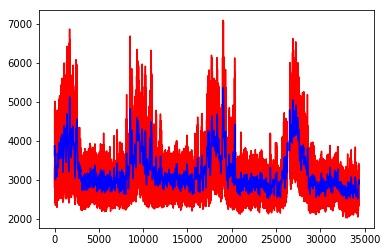

In [3]:
dem_map = {}
regions = ['TIDC', 'BANC', 'CISO', 'LDWP']
for region in regions:
    file_path = '../get_eia_demand_data/data/{}.csv'.format(region)
    dem_map[region] = pd.read_csv(file_path, #index_col='time',
                       dtype={'demand (MW)':np.float64},
                      parse_dates=True, na_values=['MISSING', 'EMPTY'])
    
    # Set all negative and zero values to NAN
    dem_map[region]['demand (MW)'] = dem_map[region]['demand (MW)'].mask(dem_map[region]['demand (MW)'] <= 0.)
    
    # Add deltas
    dem_map[region] = add_deltas(dem_map[region])
    
    n, bins, patches = plt.hist(dem_map[region]['diff_pre'], 100, alpha=0.2, label='pre')
    plt.yscale('log', nonposy='clip')
    plt.savefig('diff_pre_{}.png'.format(region))
    n, bins, patches = plt.hist(dem_map[region]['diff_post'], 100, alpha=0.2, label='post')
    plt.yscale('log', nonposy='clip')
    plt.savefig('diff_post_{}.png'.format(region))
    
    # Calculate IQR for the deltas
    iqr = np.percentile(dem_map[region]['diff_pre'].dropna(), 75) - \
                np.percentile(dem_map[region]['diff_pre'].dropna(), 25)
    
    print("iqr pre {:.2f} x 5 = {:.2f}".format(iqr, iqr*5))
    print('diff_pre 25% {:.2f}  75% {:.2f}'.format(np.percentile(dem_map[region]['diff_pre'].dropna(), 25),
                                                  np.percentile(dem_map[region]['diff_pre'].dropna(), 75)))
    
    #print(dem_map[region].describe().round(2))
    multiplier_double = 4
    multiplier_single = 6
    dem_map[region] = filter_deltas(dem_map[region], iqr, multiplier_double, multiplier_single)
    
    
    # Filter on extreme demand values
    multiplier = 10
    dem_map[region] = filter_extrems(dem_map[region], multiplier)
    
    
    # Add rolling 48 hr average
    dem_map[region] = add_48hr_rolling(dem_map[region])

    #print(dem_map[region].head())
    #print(dem_map[region].loc[1000:1005])

    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(dem_map[region]['demand (MW)'], 'r-', label='demand')
    ax.plot(dem_map[region]['rolling48'], 'b-', label='rolling 48hr')
    plt.savefig('demand_{}.png'.format(region))

In [4]:
df = dem_map['CISO']
for k, v in dem_map.items():
    print(k)
    kwargs = {k : lambda x: v['demand (MW)'],
              '{}_Lag1'.format(k) : lambda x: np.roll(v['demand (MW)'], +1),
             }
    df = df.assign(**kwargs)
print(df.head())

TIDC
BANC
CISO
LDWP
  series_id          time  year  month  day  hour  demand (MW)  \
0      CISO  20150701T05Z  2015      7    1     6          NaN   
1      CISO  20150701T06Z  2015      7    1     7          NaN   
2      CISO  20150701T07Z  2015      7    1     8          NaN   
3      CISO  20150701T08Z  2015      7    1     9      31486.0   
4      CISO  20150701T09Z  2015      7    1    10      28989.0   

   forecast demand (MW)  diff_pre  diff_post     rolling48   TIDC  TIDC_Lag1  \
0                   NaN       NaN        NaN  32744.952381    NaN      397.0   
1                   NaN       NaN        NaN  32921.863636    NaN        NaN   
2                   NaN       NaN        NaN  33034.521739    NaN        NaN   
3               28653.0       NaN     2497.0  33018.666667  408.0        NaN   
4               26895.0   -2497.0     1573.0  32890.960000  380.0      408.0   

     BANC  BANC_Lag1     CISO  CISO_Lag1    LDWP  LDWP_Lag1  
0     NaN     2490.0      NaN    24535.0

In [5]:
for remove in ['series_id', 'year', 'month', 'day', 
               'hour', 'demand (MW)', 'forecast demand (MW)',
               'time',
               'diff_pre', 'diff_post'
              ]:
    df = df.drop(remove, axis=1)
df.head()

,rolling48,TIDC,TIDC_Lag1,BANC,BANC_Lag1,CISO,CISO_Lag1,LDWP,LDWP_Lag1
0,32744.952381,NaN,397.0,NaN,2490.0,NaN,24535.0,NaN,3265.0
1,32921.863636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,33034.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33018.666667,408.0,NaN,2513.0,NaN,31486.0,NaN,3298.0,NaN
4,32890.960000,380.0,408.0,2275.0,2513.0,28989.0,31486.0,3045.0,3298.0


In [6]:
df.describe().round(2)

,rolling48,TIDC,TIDC_Lag1,BANC,BANC_Lag1,CISO,CISO_Lag1,LDWP,LDWP_Lag1
count,34338.00,31469.00,31469.00,33613.00,33613.00,33992.00,33992.00,33912.00,33912.00
mean,25917.50,296.43,296.43,1986.62,1986.62,25944.79,25944.79,3245.48,3245.48
std,3651.13,75.91,75.91,497.68,497.68,5078.04,5078.04,752.65,752.65
min,18000.27,183.00,183.00,1183.00,1183.00,13850.00,13850.00,2019.00,2019.00
25%,23489.31,246.00,246.00,1670.00,1670.00,22243.75,22243.75,2703.00,2703.00
50%,24814.16,278.00,278.00,1879.00,1879.00,25153.00,25153.00,3126.00,3126.00
75%,28031.87,316.00,316.00,2100.00,2100.00,28064.25,28064.25,3534.00,3534.00
max,38320.38,653.00,653.00,4318.00,4318.00,49899.00,49899.00,7095.00,7095.00


In [7]:
df.isna().sum(axis=0)

rolling48       1
TIDC         2870
TIDC_Lag1    2870
BANC          726
BANC_Lag1     726
CISO          347
CISO_Lag1     347
LDWP          427
LDWP_Lag1     427
dtype: int64

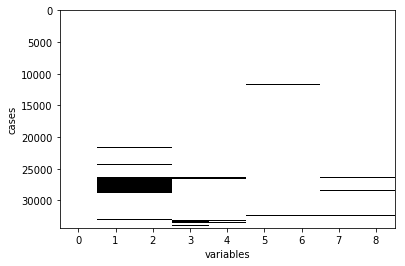

In [8]:
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

In [9]:
# Just another method to run MICE
imp = smi.MICEData(df)
fm = 'CISO ~ CISO_Lag1 + TIDC + TIDC_Lag1 + LDWP + LDWP_Lag1 + BANC + BANC_Lag1'
mice = smi.MICE(fm, sm.OLS, imp)
results = []
for k in range(10):
    x = mice.next_sample()
    results.append(x)
    imp.data.to_csv('data%02d.csv' % len(results))

/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:1081: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ix = dxi[[jj, ir]]
/anaconda3/lib/python3.7/site-packages/statsmodels/imputation/mice.py:1082: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  iz = ixm[[jj, ix]]


In [10]:
# Impute and save the imputed datasets
# Not sure what the burn in is for these
imp = smi.MICEData(df)
imp.set_imputer('CISO', formula='CISO_Lag1 + TIDC + TIDC_Lag1 + LDWP + LDWP_Lag1 + BANC + BANC_Lag1')
for j in range(3):
    imp.update_all()
    imp.data.to_csv('data%02d.csv' % j)

In [11]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, scipy, patsy, statsmodels

Software,Version
Python,3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.4.0
OS,Darwin 18.6.0 x86_64 i386 64bit
pandas,0.24.2
numpy,1.16.2
matplotlib,3.0.3
seaborn,0.9.0
scipy,1.2.1
patsy,0.5.1
statsmodels,0.9.0
